In [2]:
import pandas as pd
df_train = pd.read_csv('Kaggle-Give-Me-Some-Data\cs-training.csv')

In [3]:
df = df_train.fillna(df_train.mean())  # Fill-in the missing values with the column means

In [4]:
df = df.drop(columns=['Unnamed: 0']) #drop the first column

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

x = df.drop(columns=['SeriousDlqin2yrs'])
y = df['SeriousDlqin2yrs']
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(x)  #standardization 

According to the L1 regularization, we find the two most important features which are `NumberOfTime30-59DaysPastDueNotWorse` adn `age`.

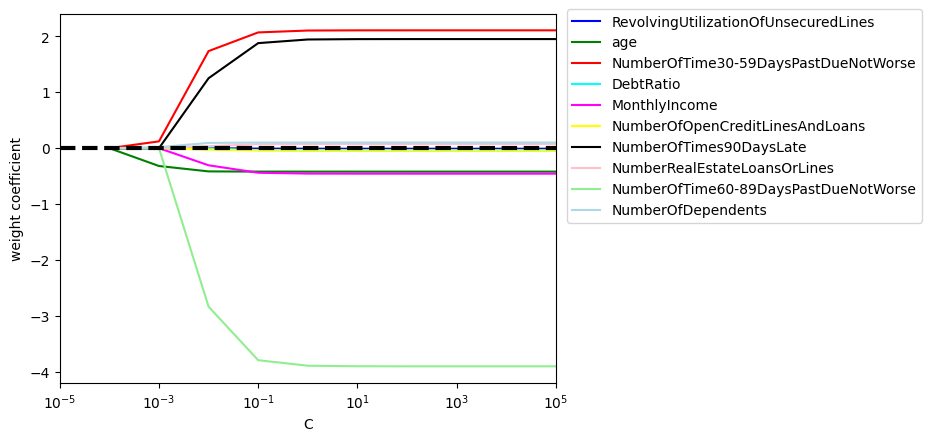

In [5]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue']

weights, params = [], []
for c in np.arange(-4.,6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, solver='liblinear', 
                            multi_class='ovr', random_state=0)
    lr.fit(X_train_std, y)
    weights.append(lr.coef_[0])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
plt.show()

# Apply LR/SVM/decision tree

## LR

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
x_features =  x.iloc[:,[1,2]]
x_features_std = stdsc.fit_transform(x_features)
y_np = y.to_numpy()

# Define the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Instantiate the LogisticRegression model
lr = LogisticRegression(random_state=1, solver='lbfgs', multi_class='ovr')

# Instantiate GridSearchCV
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(x_features_std, y_np)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best parameters: {'C': 0.001}
Best score: 0.9333266666666666


In [7]:
lr = LogisticRegression(C=0.001, random_state=1, solver='lbfgs', multi_class='ovr')
lr.fit(x_features_std, y_np)

LogisticRegression(C=0.001, multi_class='ovr', random_state=1)

## SVM

In [9]:
from sklearn.svm import SVC
svm1 = SVC(kernel='linear', C=0.001, random_state=1)
svm1.fit(x_features_std, y_np)
C1 = svm1.score(x_features_std,y_np)

svm2 = SVC(kernel='linear', C=0.01, random_state=1)
svm2.fit(x_features_std, y_np)
C2 = svm2.score(x_features_std,y_np)

if C1 > C2:
    print("Best parameters:{'C':0.001}")
    print(f"Best score:{C1}")
else:
    print("Best parameters:{'C':0.001}")
    print(f"Best score:{C2}")


Best parameters:{'C':0.001}
Best score:0.93316


In [10]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=0.001, random_state=1)
svm.fit(x_features_std, y_np)

SVC(C=0.001, kernel='linear', random_state=1)

## SVM decision tree

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Define a range of max_depth values to try
max_depth_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Initialize the best parameters
best_max_depth = None
best_score = -1

# Loop over the max_depth values
for max_depth in max_depth_values:
    # Create a decision tree model with the current max_depth value
    tree_model = DecisionTreeClassifier(criterion='gini', max_depth=max_depth, random_state=1)
    
    # Perform cross-validation evaluation
    scores = cross_val_score(tree_model, x_features_std, y_np, cv=5)
    avg_score = np.mean(scores)
    
    # Update the best score and best parameters if the current score is higher
    if avg_score > best_score:
        best_score = avg_score
        best_max_depth = max_depth

# Output the best parameters and score
print("Best max_depth value:", best_max_depth)
print("Best average score:", best_score)


Best max_depth value: 7
Best average score: 0.9334999999999999


In [12]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=7, 
                                    random_state=1)
tree_model.fit(x_features_std, y_np)

DecisionTreeClassifier(max_depth=7, random_state=1)

# Visualize the classifiers

In [13]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.1):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    print(xx1.shape)
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='g',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

## LR

(254, 94)


C:\Users\Allwings\AppData\Local\Temp\ipykernel_48152\2301821036.py:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


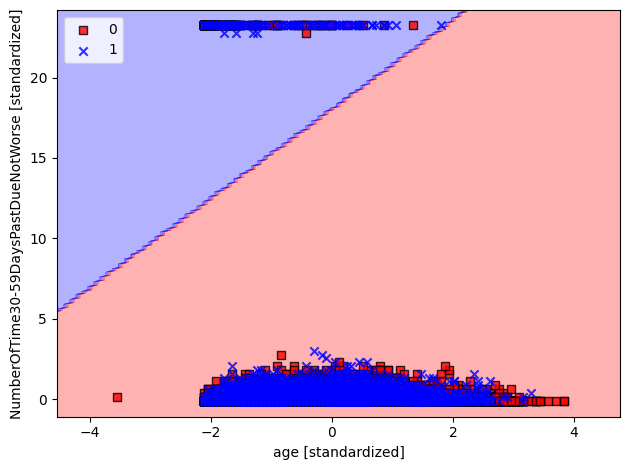

In [14]:
plot_decision_regions(X = x_features_std, y = y_np,
                      classifier=lr)
plt.xlabel('age [standardized]')
plt.ylabel('NumberOfTime30-59DaysPastDueNotWorse [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## SVM

(254, 94)


C:\Users\Allwings\AppData\Local\Temp\ipykernel_48152\2301821036.py:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


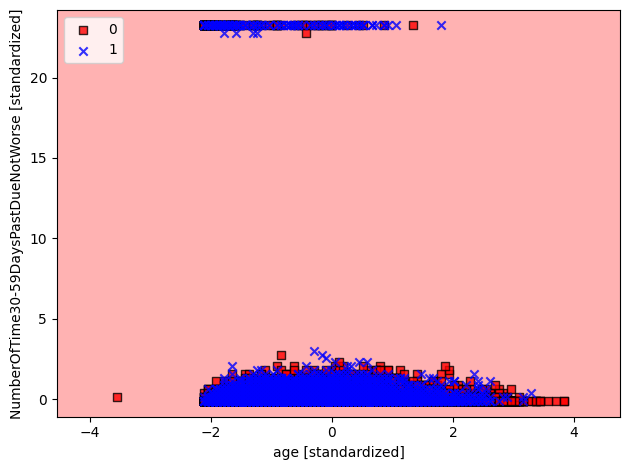

In [15]:
plot_decision_regions(x_features_std, 
                      y_np,
                      classifier=svm)
plt.xlabel('age [standardized]')
plt.ylabel('NumberOfTime30-59DaysPastDueNotWorse [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## decision tree

(254, 94)


C:\Users\Allwings\AppData\Local\Temp\ipykernel_48152\2301821036.py:24: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


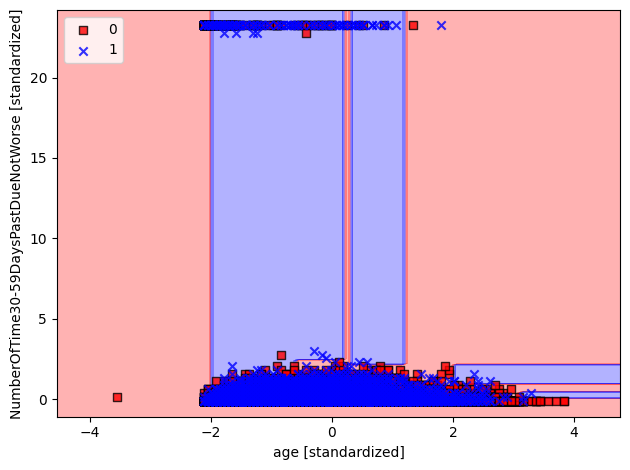

In [17]:
plot_decision_regions(x_features_std, y_np,
                      classifier=tree_model)

plt.xlabel('age [standardized]')
plt.ylabel('NumberOfTime30-59DaysPastDueNotWorse [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()